In [21]:
import re
import json
import time
import chardet
import requests
import xmltodict
import numpy as np
import pandas as pd
import tushare as ts
import baostock as bs
from lxml import etree
from scipy import stats,interpolate
from scipy.optimize import fsolve,brentq
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta

# 说明文档

1.项目概要：

本项目旨在计算上证50ETF期权和沪深300股指期权的隐含波动率曲面。程序从不同网站爬取(白嫖)计算隐含波动率所需的数据，分别基于BSM和Black model计算隐含波动率。

2.数据来源：
* 期权类数据
    * 上证50ETF期权来自tushare pro数据接口（积分起码要120）
    * 沪深300股指期权从中金所官网爬取
* 现货价格（基于BSM公式）
    * 上证50等ETF数据来自指数基金网<u>www.indexfunds.com.cn</u>，如果数据缺失就用天天基金的NAV替代
    * 沪深300指数取自baostock（证券宝）数据接口（我也没想到tushare连指数都要权限。。。）
* 期货价格（基于Black模型）
    * 上证50、沪深300股指期货数据均从中金所官网爬取
* 无风险利率
    * 本项目采用的无风险利率由贴现国债收益率曲线插值得到
    * 国债收益率数据来自中国货币网<u>www.chinamoney.com.cn</u>

3.原理简介：
本项目分别用BSM和Black模型对期权进行定价，用scipy的brentq函数从期权市场价格中反推隐含波动率。
* BSM模型公式
    * $c = SN(d_1)-Ke^{-r(T-t)}N(d_2)$
    * $d1 = \frac{ln(\frac{S}{K})+(\frac{\sigma^2}{2}+r)(T-t)}{\sigma \sqrt{T-t}}$,$d2 = d1-\sigma \sqrt{T-t}$
* Black模型公式
    * $c = Fe^{-r(T-t)}N(d_1)-Ke^{-r(T-t)}N(d_2)$
    * $d1 = \frac{ln(\frac{F}{K})+\frac{\sigma^2}{2}(T-t)}{\sigma \sqrt{T-t}}$,$d2 = d1-\sigma \sqrt{T-t}$

# 获取期权数据

In [43]:
def get_50opt_data(tradedate,token):
    # 从Tushare得到期权数据
    pro = ts.pro_api(token)
    opt_info = pro.opt_basic(exchange='SSE', fields='ts_code,name,maturity_date,call_put,exercise_price')
    opt_info = opt_info[opt_info['name'].str.contains('50ETF')]
    opt_price = pro.opt_daily(trade_date=tradedate,exchange='SSE')
    assert len(opt_price) > 0,'非交易日没有数据，请输入交易日'
    opt_price = opt_price[opt_price['ts_code'].isin(opt_info['ts_code'].tolist())].reset_index(drop=True)
    opt_info = opt_info[opt_info['ts_code'].isin(opt_price['ts_code'].tolist())].reset_index(drop=True)
    # data processing
    opt_price = opt_price.rename(columns={'trade_date':'tradedate','close':'closeprice'})
    opt_price['expiredate'] = [opt_info[opt_info['ts_code']==opt_price['ts_code'].iloc[i]]['maturity_date'].iloc[0] for i in range(len(opt_price))]
    opt_price['cp'] = [opt_info[opt_info['ts_code']==opt_price['ts_code'].iloc[i]]['call_put'].iloc[0] for i in range(len(opt_price))]
    opt_price['K'] = [opt_info[opt_info['ts_code']==opt_price['ts_code'].iloc[i]]['exercise_price'].iloc[0] for i in range(len(opt_price))]
    opt_price['tau'] = pd.to_datetime(opt_price['expiredate'],format='%Y%m%d')-pd.to_datetime(opt_price['tradedate'],format='%Y%m%d')
    opt_price['tau'] = opt_price['tau'].apply(lambda x:x.days)
    opt_price = opt_price.sort_values(by=['tau','K']).reset_index(drop=True)
    return opt_price[['tradedate','K','tau','closeprice','cp']]

In [49]:
def get_300opt_data(tradedate):
    # 从中金所官网爬取IF,IH,IC,IO数据    
    date = datetime(int(tradedate[0:4]),int(tradedate[4:6]),int(tradedate[6:8]))
    total = []
    for i in range(1):
        datestr = datetime.strftime(date,'%Y%m%d')
        datestr = datestr[0:6]+'/'+datestr[-2:]
        url = 'http://www.cffex.com.cn/sj/hqsj/rtj/{}/index.xml'.format(datestr)
        res = requests.get(url)
        # XML转JSON
        js = json.loads(json.dumps(xmltodict.parse(res.text)))
        if 'dailydatas' in list(js.keys()):
            item = js['dailydatas']['dailydata']
            total.extend(item)
        date = date-relativedelta(days=1)
    ccfex = pd.DataFrame(total)
    assert len(ccfex) > 0,'非交易日没有数据，请输入交易日'
    opt_price = ccfex[(ccfex['productid']=='IO')&(ccfex['tradingday']==tradedate)].reset_index(drop=True)
    opt_price = opt_price.rename(columns={'tradingday':'tradedate'})
    opt_price['closeprice'] = opt_price['closeprice'].astype(float)
    opt_price['K'] = opt_price['instrumentid'].apply(lambda x: int(x.split('-')[-1]))
    opt_price['cp'] = opt_price['instrumentid'].apply(lambda x: x.split('-')[-2])
    opt_price['tau'] = pd.to_datetime(opt_price['expiredate'],format='%Y%m%d')-pd.to_datetime(opt_price['tradedate'],format="%Y%m%d")
    opt_price['tau'] = opt_price['tau'].apply(lambda x:x.days)
    opt_price = opt_price.sort_values(by=['tau','K']).reset_index(drop=True)
    return opt_price[['tradedate','K','tau','closeprice','cp']]

# 获取现货价格(BSM)

In [108]:
def get_etf_price(opt_price,tradedate,fundid):
    # fundid = '510050'或者沪深300ETF也行
    url = 'http://www.indexfunds.com.cn/funds/etf/quoday?date={}'.format(tradedate[0:4]+'-'+tradedate[4:6]+'-'+tradedate[6:8])
    res = requests.get(url)
    selector = etree.HTML(res.text)
    fund_df = pd.DataFrame()
    fund_df['date'] = [item.xpath('./td[1]/text()')[0] for item in selector.xpath('//*[@id="main"]/div[1]/div/table/tbody/tr')]
    fund_df['code'] = [item.xpath('./td[2]/text()')[0] for item in selector.xpath('//*[@id="main"]/div[1]/div/table/tbody/tr')]
    fund_df['name'] = [item.xpath('./td[3]/text()')[0] for item in selector.xpath('//*[@id="main"]/div[1]/div/table/tbody/tr')]
    fund_df['nav'] = [float(item.xpath('./td[4]/text()')[0]) for item in selector.xpath('//*[@id="main"]/div[1]/div/table/tbody/tr')]
    fund_df['close'] = [float(item.xpath('./td[5]/text()')[0]) for item in selector.xpath('//*[@id="main"]/div[1]/div/table/tbody/tr')]
    # 判断是否有收盘价数据，如果没有就用天天基金的净值代替
    if fundid in fund_df['code'].tolist():
        close = fund_df[fund_df['code'] == fundid]['close'].iloc[0]
    else:
        close = get_etf_data(tradedate)
    return [close for i in range(len(opt_price))]

def get_etf_data(tradedate):
    #从天天基金爬单位净值，但没有收盘价数据
    tradedate = tradedate[0:4] + '-' + tradedate[4:6] + '-' + tradedate[6:8]
    url='http://fund.eastmoney.com/f10/F10DataApi.aspx?type=lsjz'\
        '&code=510050&page=1&sdate={}&edate={}&per=1'.format(tradedate,tradedate)
    res = requests.get(url)
    text = res.text
    text_html=re.findall('content:"(.*?)",records:',text)[0]
    html = etree.HTML(text_html)
    html_data = html.xpath('//tr/td')
    info = [item.text for item in html_data]
    # 返回NAV
    return float(info[1])


In [5]:
def get_index_data(opt_price,tradedate,code):
    # code="sh.000300"
    date = tradedate[0:4]+'-'+tradedate[4:6]+'-'+tradedate[6:8]
    lg = bs.login()
    rs = bs.query_history_k_data_plus(code,
        "date,code,open,high,low,close,preclose,volume,amount,pctChg",
        start_date=date, end_date=date, frequency="d")
    data_list = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)
    return [result['close'].astype(float).iloc[0] for i in range(len(opt_price))]

# 期货价格插值(Black model)

In [31]:
def get_inter_fut_price(opt_price,futid):

    # 从中金所官网爬取IF,IH,IC,IO数据
    tradedate = opt_price['tradedate'].unique()[0]
    date = datetime(int(tradedate[0:4]),int(tradedate[4:6]),int(tradedate[6:8]))
    total = []
    for i in range(10):
        datestr = datetime.strftime(date,'%Y%m%d')
        datestr = datestr[0:6]+'/'+datestr[-2:]
        url = 'http://www.cffex.com.cn/sj/hqsj/rtj/{}/index.xml'.format(datestr)
        res = requests.get(url)
        # XML转JSON
        js = json.loads(json.dumps(xmltodict.parse(res.text)))
        if 'dailydatas' in list(js.keys()):
            item = js['dailydatas']['dailydata']
            total.extend(item)
        date = date-relativedelta(days=1)
    ccfex = pd.DataFrame(total)
    fut_data = ccfex[(ccfex['productid']==futid)].reset_index(drop=True)
    fut_data['tau'] = pd.to_datetime(fut_data['expiredate'],format='%Y%m%d')-pd.to_datetime(fut_data['tradingday'],format='%Y%m%d')
    fut_data['tau'] = fut_data['tau'].apply(lambda x:x.days)

    fut_inter = []
    for i in range(len(opt_price)):
        day = opt_price['tradedate'].iloc[i]
        fut_df = fut_data[fut_data['tradingday']==day].reset_index(drop=True)
        term = fut_df['tau'].values
        if fut_df['productid'].iloc[0] == 'IH':
            price = fut_df['closeprice'].astype(float).values/1000
        elif fut_df['productid'].iloc[0] == 'IF':
            price = fut_df['closeprice'].astype(float).values
        tau = opt_price['tau'].iloc[i]
        #inter_p = np.interp(tau,term,price)
        inter_p = interpolate.interp1d(term,price,kind='linear',fill_value='extrapolate')
        fut_inter.append(float(inter_p(tau)))
    #opt_price['F'] = fut_inter
    return fut_inter

# 无风险利率插值

In [35]:
def get_inter_rf_rate(opt_price):
    # 从中国货币网爬取贴现国债收益率曲线
    tradedate = opt_price['tradedate'].unique()[0]
    startdate = tradedate[0:4]+'-'+tradedate[4:6]+'-'+tradedate[6:8] 
    enddate = tradedate[0:4]+'-'+tradedate[4:6]+'-'+tradedate[6:8]
    rate_list = []
    url_init = 'http://www.chinamoney.com.cn/ags/ms/cm-u-bk-currency/ClsYldCurvHis?lang=CN&reference=1&bondType=CYCC000&startDate={}&endDate={}&termId=1&pageNum=1'.format(startdate,enddate)
    res1 = requests.get(url_init)
    js = json.loads(res1.text)
    pagetotal = js['data']['pageTotal']
    for i in range(1,pagetotal+1):
        urls = url_init.replace('pageNum=1','pageNum'+'='+str(i))
        res2 = requests.get(urls)
        js = json.loads(res2.text)
        rate_list.extend(js['records'])

    rate_df = pd.DataFrame()
    rate_df['date'] = pd.DataFrame(rate_list)['newDateValueCN'].apply(lambda x:(x.replace('-','')))
    rate_df['tau'] = pd.DataFrame(rate_list)['yearTermStr'].astype(float)*360
    rate_df['rate'] = pd.DataFrame(rate_list)['currentYieldStr'].astype(float)

    rf_inter = []
    for i in range(len(opt_price)):
        day = opt_price['tradedate'].iloc[i]
        rf_df = rate_df[rate_df['date']==day].reset_index(drop=True)
        term = rf_df['tau'].values
        rate = rf_df['rate'].values
        tau = opt_price['tau'].iloc[i]
        #inter_rf = np.interp(tau,term,rate)/100
        inter_rf = interpolate.interp1d(term,rate,kind='linear',fill_value='extrapolate')
        rf_inter.append(float(inter_rf(tau))/100)

    #opt_price['rf'] = rf_inter
    return rf_inter

# 构造期权定价误差

In [153]:
class Delta:
    def __init__(self, target, U, K, rf, tau, cp, model):
        self.targetValue = target   # option price
        self.U = U                  # underliying asset price
        self.K = K                  # exercise price
        self.rf = rf                # riskfree rate
        self.tau = tau              # maturity
        self.cp = cp                # call or put
        self.model = model          # pricing model: "bsm" or "blk"
    
    def __call__(self, x):
        if self.model == 'blk':
            return self.blkprice(self.U, self.K, self.rf, self.tau, x, self.cp) - self.targetValue
        elif self.model == 'bsm':
            return self.blsprice(self.U, self.K, self.rf, self.tau, x, self.cp) - self.targetValue
        
    def blkprice(self,F,K,rf,tau,vol,cp):
        d1 = (np.log(F/K) + (tau*vol**2)/2) / (vol*np.sqrt(tau))
        d2 = d1 - vol*np.sqrt(tau)
        if cp == 'C':
            price = F*np.exp(-rf*tau)*stats.norm.cdf(d1) - K*np.exp(-rf*tau)*stats.norm.cdf(d2)
        elif cp == 'P':
            price = K*np.exp(-rf*tau)*stats.norm.cdf(-d2) - F*np.exp(-rf*tau)*stats.norm.cdf(-d1)
        return price

    def blsprice(self,S,K,rf,tau,vol,cp):
        d1 = ( np.log(S/K) + (rf+vol**2)*tau/2 ) / (vol*np.sqrt(tau))
        d2 = d1 - vol*np.sqrt(tau)
        if cp == 'C':
            price = S*stats.norm.cdf(d1) - K*np.exp(-rf*tau)*stats.norm.cdf(d2)
        elif cp == 'P':
            price = K*np.exp(-rf*tau)*stats.norm.cdf(-d2) - S*stats.norm.cdf(-d1)
        return price
    

In [156]:
def get_opt_iv(opt_price,cost_function,iv_model):
    iv_list = []
    for i in range(len(opt_price)):
        row = opt_price.iloc[i,:]
        target = row['closeprice']
        delta = Delta(target,row['U'],row['K'],row['rf'],row['tau']/360,row['cp'],iv_model)
        # 二分法求解IV，搜索范围是-1<IV<10
        imp_vol = brentq(delta,-1,10)
        iv_list.append(imp_vol)
    return iv_list

# 调用函数

In [154]:
# 必要参数
tradedate = '20200203'
mytoken = '此处应有token'
# 显示设置
pd.set_option('display.float_format', lambda x: '%.6f' % x)

## 50ETF期权BSM隐含波动率

In [157]:
opt50_bsm = get_50opt_data(tradedate,mytoken)
opt50_bsm['U'] = get_etf_price(opt50_bsm,tradedate,'510050')
opt50_bsm['rf'] = get_inter_rf_rate(opt50_bsm)
opt50_bsm['iv'] = get_opt_iv(opt50_bsm,Delta,'bsm')
opt50_bsm.head(10)

,tradedate,K,tau,closeprice,cp,U,rf,iv
0,20200203,2.750000,23,0.044600,C,2.720000,0.018294,0.206819
1,20200203,2.750000,23,0.150000,P,2.720000,0.018294,0.494426
2,20200203,2.800000,23,0.029500,C,2.720000,0.018294,0.216672
3,20200203,2.800000,23,0.184500,P,2.720000,0.018294,0.514044
4,20200203,2.850000,23,0.020900,C,2.720000,0.018294,0.234197
5,20200203,2.850000,23,0.229200,P,2.720000,0.018294,0.562968
6,20200203,2.900000,23,0.013900,C,2.720000,0.018294,0.244149
7,20200203,2.900000,23,0.275000,P,2.720000,0.018294,0.609960
8,20200203,2.950000,23,0.009500,C,2.720000,0.018294,0.255787
9,20200203,2.950000,23,0.313500,P,2.720000,0.018294,0.623041


## 50ETF期权Black隐含波动率

In [158]:
opt50_blk = get_50opt_data(tradedate,mytoken)
opt50_blk['U'] = get_inter_fut_price(opt50_blk,'IH')
opt50_blk['rf'] = get_inter_rf_rate(opt50_blk)
opt50_blk['iv'] = get_opt_iv(opt50_blk,Delta,'blk')
opt50_blk.head(10)
#导出数据用matlab重新算了一遍发现结果几乎一样（不愧是我）
#output = test[['tradedate','F','K','rf','tau','closeprice']].astype(float)
#output['cp'] = test['cp'].apply(lambda x:1 if x=='C' else 0)
#output.to_csv('C:/users/coolgan/desktop/test.csv',index=False)

,tradedate,K,tau,closeprice,cp,U,rf,iv
0,20200203,2.750000,23,0.044600,C,2.647707,0.018294,0.317338
1,20200203,2.750000,23,0.150000,P,2.647707,0.018294,0.330565
2,20200203,2.800000,23,0.029500,C,2.647707,0.018294,0.308904
3,20200203,2.800000,23,0.184500,P,2.647707,0.018294,0.322366
4,20200203,2.850000,23,0.020900,C,2.647707,0.018294,0.314699
5,20200203,2.850000,23,0.229200,P,2.647707,0.018294,0.347963
6,20200203,2.900000,23,0.013900,C,2.647707,0.018294,0.315216
7,20200203,2.900000,23,0.275000,P,2.647707,0.018294,0.371889
8,20200203,2.950000,23,0.009500,C,2.647707,0.018294,0.320005
9,20200203,2.950000,23,0.313500,P,2.647707,0.018294,0.337103


## 沪深300股指期权BSM隐含波动率

In [159]:
opt300_bsm = get_300opt_data(tradedate)
opt300_bsm['U'] = get_index_data(opt300_bsm,tradedate,"sh.000300")
opt300_bsm['rf'] = get_inter_rf_rate(opt300_bsm)
opt300_bsm['iv'] = get_opt_iv(opt300_bsm,Delta,'bsm')
opt300_bsm.head(10)

login success!


,tradedate,K,tau,closeprice,cp,U,rf,iv
0,20200203,3550,18,137.000000,C,3688.357000,0.018169,0.000000
1,20200203,3550,18,106.800000,P,3688.357000,0.018169,0.521561
2,20200203,3600,18,106.200000,C,3688.357000,0.018169,0.144038
3,20200203,3600,18,133.000000,P,3688.357000,0.018169,0.538952
4,20200203,3650,18,83.800000,C,3688.357000,0.018169,0.185565
5,20200203,3650,18,166.800000,P,3688.357000,0.018169,0.571659
6,20200203,3700,18,71.000000,C,3688.357000,0.018169,0.227934
7,20200203,3700,18,192.600000,P,3688.357000,0.018169,0.572443
8,20200203,3750,18,59.800000,C,3688.357000,0.018169,0.258754
9,20200203,3750,18,232.600000,P,3688.357000,0.018169,0.610060


## 沪深300股指期权Black隐含波动率

In [160]:
opt300_blk = get_300opt_data(tradedate)
opt300_blk['U'] = get_inter_fut_price(opt300_blk,'IF')
opt300_blk['rf'] = get_inter_rf_rate(opt300_blk)
opt300_blk['iv'] = get_opt_iv(opt300_blk,Delta,'blk')
opt300_blk.head(10)

,tradedate,K,tau,closeprice,cp,U,rf,iv
0,20200203,3550,18,137.000000,C,3591.200000,0.018169,0.362264
1,20200203,3550,18,106.800000,P,3591.200000,0.018169,0.397065
2,20200203,3600,18,106.200000,C,3591.200000,0.018169,0.345030
3,20200203,3600,18,133.000000,P,3591.200000,0.018169,0.401298
4,20200203,3650,18,83.800000,C,3591.200000,0.018169,0.343154
5,20200203,3650,18,166.800000,P,3591.200000,0.018169,0.419776
6,20200203,3700,18,71.000000,C,3591.200000,0.018169,0.361554
7,20200203,3700,18,192.600000,P,3591.200000,0.018169,0.403793
8,20200203,3750,18,59.800000,C,3591.200000,0.018169,0.376825
9,20200203,3750,18,232.600000,P,3591.200000,0.018169,0.425474


In [38]:
output = opt300.copy()
output['cp'] = output['cp'].apply(lambda x: 1 if x=='C' else 0)
output.to_csv('C:/users/coolgan/desktop/test.csv',index=False)

# 可视化

In [115]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

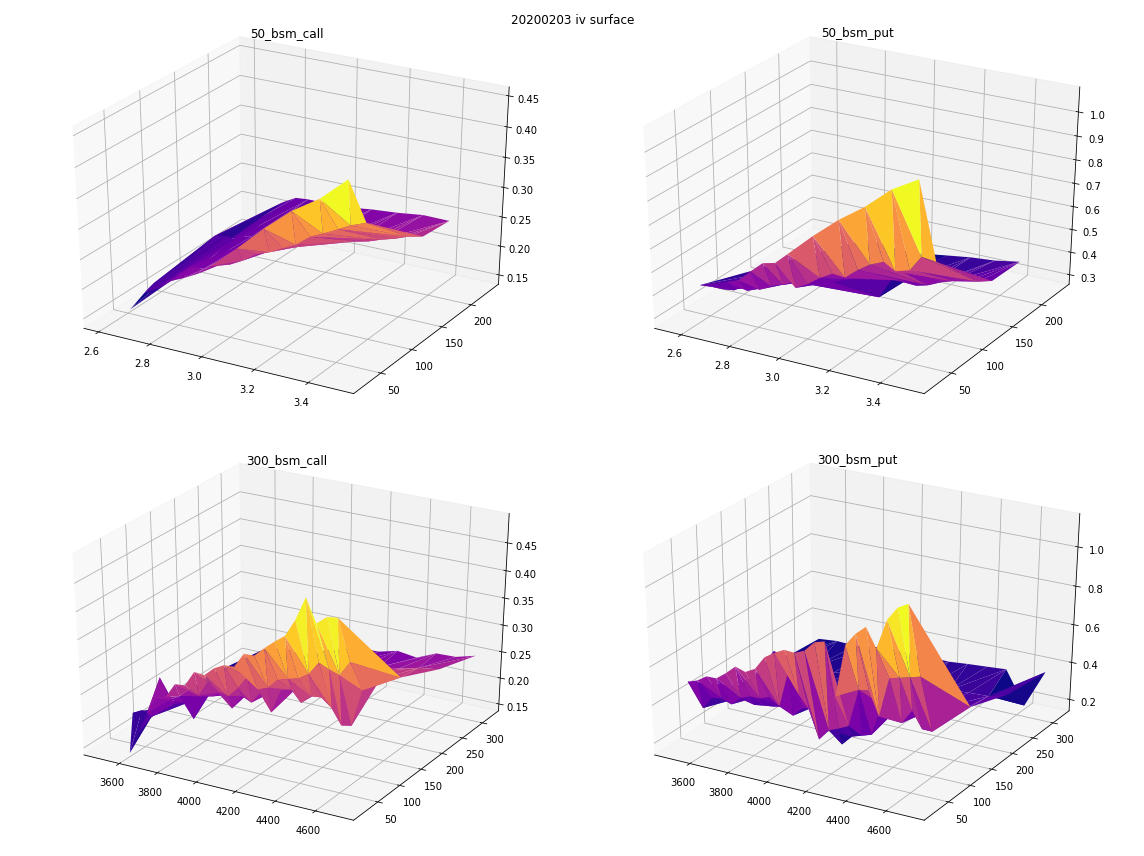

In [147]:
opt50_bsm = opt50_bsm[opt50_bsm['iv']>1e-10].reset_index(drop=True)
opt300_bsm = opt300_bsm[opt300_bsm['iv']>1e-10].reset_index(drop=True)

opt50_bsm_c = opt50_bsm[opt50_bsm['cp']=='C'].reset_index(drop=True)
opt50_bsm_p = opt50_bsm[opt50_bsm['cp']=='P'].reset_index(drop=True)
opt300_bsm_c = opt300_bsm[opt300_bsm['cp']=='C'].reset_index(drop=True)
opt300_bsm_p = opt300_bsm[opt300_bsm['cp']=='P'].reset_index(drop=True)

fig = plt.figure(figsize=(16,12))
colormap = 'plasma'
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_trisurf(opt50_bsm_c['K'],opt50_bsm_c['tau'],opt50_bsm_c['iv'],cmap=colormap)
ax1.set_title('50_bsm_call')
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_trisurf(opt50_bsm_p['K'],opt50_bsm_p['tau'],opt50_bsm_p['iv'],cmap=colormap)
ax2.set_title('50_bsm_put')
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_trisurf(opt300_bsm_c['K'],opt300_bsm_c['tau'],opt300_bsm_c['iv'],cmap=colormap)
ax3.set_title('300_bsm_call')
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_trisurf(opt300_bsm_p['K'],opt300_bsm_p['tau'],opt300_bsm_p['iv'],cmap=colormap)
ax4.set_title('300_bsm_put')
plt.suptitle(tradedate + ' iv surface')
plt.tight_layout()

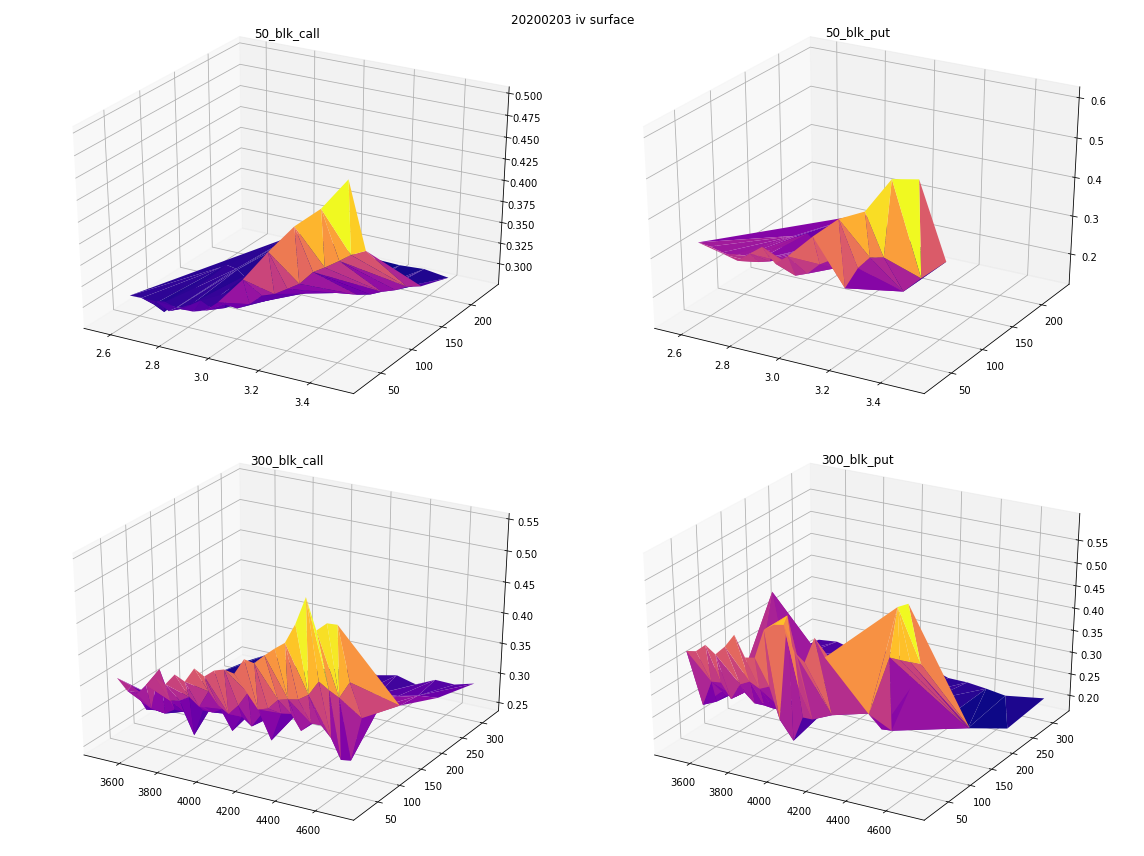

In [152]:
opt50_blk = opt50_blk[opt50_blk['iv']>1e-10].reset_index(drop=True)
opt300_blk = opt300_blk[opt300_blk['iv']>1e-10].reset_index(drop=True)

opt50_blk_c = opt50_blk[opt50_blk['cp']=='C'].reset_index(drop=True)
opt50_blk_p = opt50_blk[opt50_blk['cp']=='P'].reset_index(drop=True)
opt300_blk_c = opt300_blk[opt300_blk['cp']=='C'].reset_index(drop=True)
opt300_blk_p = opt300_blk[opt300_blk['cp']=='P'].reset_index(drop=True)

fig = plt.figure(figsize=(16,12))
colormap = 'plasma'
ax1 = fig.add_subplot(221, projection='3d')
ax1.plot_trisurf(opt50_blk_c['K'],opt50_blk_c['tau'],opt50_blk_c['iv'],cmap=colormap)
ax1.set_title('50_blk_call')
ax2 = fig.add_subplot(222, projection='3d')
ax2.plot_trisurf(opt50_blk_p['K'],opt50_blk_p['tau'],opt50_blk_p['iv'],cmap=colormap)
ax2.set_title('50_blk_put')
ax3 = fig.add_subplot(223, projection='3d')
ax3.plot_trisurf(opt300_blk_c['K'],opt300_blk_c['tau'],opt300_blk_c['iv'],cmap=colormap)
ax3.set_title('300_blk_call')
ax4 = fig.add_subplot(224, projection='3d')
ax4.plot_trisurf(opt300_blk_p['K'],opt300_blk_p['tau'],opt300_blk_p['iv'],cmap=colormap)
ax4.set_title('300_blk_put')
plt.suptitle(tradedate + ' iv surface')
plt.tight_layout()